# `scipy`
A large collection of functions related to scientific computing and data analysis. Makes heavy use of `numpy` and provides a Python interface to many F77 libraries. These slides give a non-exhaustive overview of the functionality.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import numpy as np
import matplotlib.pyplot as plt

## Special functions
A large number of special functions is available in `scipy.special`. All of them accept scalars and numpy arrays as arguments.

In [2]:
from scipy import special

### Some Examples
#### $\Gamma$ function

In [3]:
special.gamma(30)

8.8417619937397008e+30

Recall that for integer values: $n! = \Gamma(n+1)$.

In [4]:
special.factorial(29) - special.gamma(30)

0.0

Factorials are actually approximated using $\Gamma$. We can force exact integer evaluation to see the error introduced by floating-point arithmetic

In [5]:
special.factorial(29, exact=True) - special.gamma(30)

1125899906842624.0

This is of the order of $10^{-16}$ as expected.

### Special Polynomials
These return a polynomial object with the coefficients.
#### Legendre polynomials

In [6]:
p = special.legendre(3)
print(p)

     3
2.5 x - 1.5 x


It can be evaluated like a function.

In [7]:
p(0.5)

-0.43749999999999994

Derivatives can be computed directly from the coefficients.

In [8]:
print(p.deriv())

     2
7.5 x - 1.5


#### Chebychev polynomials
`chebyt` are the polynomials of first kind ($T_n$), `chebyu` of second kind ($U_n$).

In [9]:
print(special.chebyt(5))

    5             4      3             2
16 x - 1.776e-15 x - 20 x + 2.665e-15 x + 5 x - 3.062e-16


Let's check the recurrence relation.
$$T_{n+1} = 2x T_n - T_{n-1}$$

In [10]:
print(special.chebyt(4) * 2 * np.poly1d([1,0]) - special.chebyt(3))

    5      3            2
16 x - 20 x + 2.22e-15 x + 5 x - 1.837e-16


In [11]:
print(special.chebyt(5))

    5             4      3             2
16 x - 1.776e-15 x - 20 x + 2.665e-15 x + 5 x - 3.062e-16


## Spherical harmonics
The implementation in `sph_harm` does *not* use the Condon–Shortley phase ($(-1)^m$ for $m>0$) common in quantum mechanics.

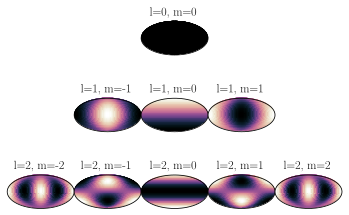

In [12]:
phi, theta = np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(0,np.pi))
gr = plt.GridSpec(3,5,wspace=0)
for l in range(3):
    for m in range(-l,l+1):
        ax = plt.subplot(gr[l,m+2], projection='mollweide')
        ax.set_title('l={}, m={}'.format(l,m))
        ax.pcolormesh(phi, 0.5 * np.pi - theta,
                      np.real(special.sph_harm(m,l,phi,theta)),
                     rasterized=True)
        ax.set_xticks([]); ax.set_yticks([])

## Constants
Many physical constants are available in the `constants` module. The data are taken from the CODATA 2014 recommendations. Values are given in SI units. More advanced handling of units attached to values is provided by the `astropy.units` package.

In [13]:
from scipy import constants

In [14]:
constants.gravitational_constant # also constants.G

6.67408e-11

In [15]:
constants.Avogadro # also constants.N_A

6.022140857e+23

Additional information is available in the dictionary `physical_constants`. Each value also has information on its unit and uncertainty.

In [16]:
constants.physical_constants['molar gas constant']

(8.3144598, 'J mol^-1 K^-1', 4.8e-06)

In [17]:
constants.physical_constants['Newtonian constant of gravitation']

(6.67408e-11, 'm^3 kg^-1 s^-2', 3.1e-15)

#### Unit conversion
A simple function to convert temperatures is provided. See `astropy.units` for a complete unit conversion package.

In [18]:
constants.convert_temperature(0.,'C', 'F')

32.0

In [19]:
constants.convert_temperature(1,'K','R')
# Kelvin to Rankine

1.8

## Interpolation
The `interpolate` module provides several polynomial and spline interpolators as well as interpolators for multidimensional data. It also provides an interface to several FITPACK routines.

In [20]:
from scipy import interpolate

In [21]:
# generate some data
x = np.linspace(0, 2 * np.pi, 101) # fine grid for plotting
f = lambda x: np.sin(x) + 0.5 * np.cos(3.5 * x)
y = f(x)
xd = x[::10]; yd = y[::10] # coarse data for fitting

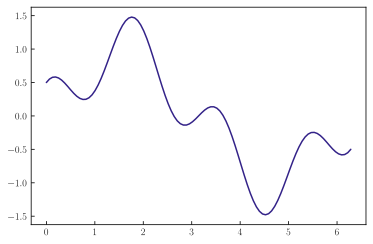

In [22]:
plt.plot(x,y)

### Simple 1D interpolation

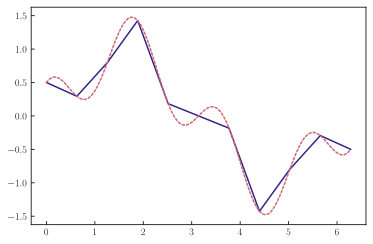

In [23]:
linear = interpolate.interp1d(xd,yd)
# linear is a callable function
plt.plot(x, linear(x))
plt.plot(x, y, ls=':')

Apart from the default, `'linear'`, other interpolation methods can be selected. Starting with `'quadratic'`, splines are used to ensure smooth derivatives.

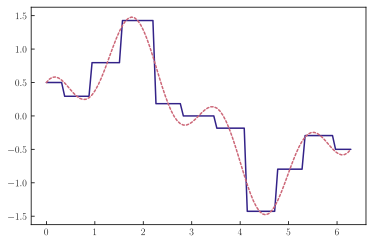

In [24]:
nearest = interpolate.interp1d(xd,yd,kind='nearest')
plt.plot(x, nearest(x))
plt.plot(x, y, ls=':')

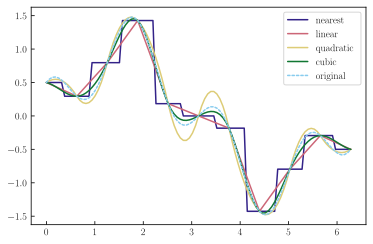

In [25]:
for k in ['nearest', 'linear', 'quadratic', 'cubic']:
    interp = interpolate.interp1d(xd, yd, kind=k)
    plt.plot(x, interp(x), label=k)
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Generic Interface
`interpolate.UnivariateSpline` provides a generic object-oriented interface to splines. It supports up to fifth order and can apply smoothing to data. Data points can be given individual weights (e.g., error estimates).

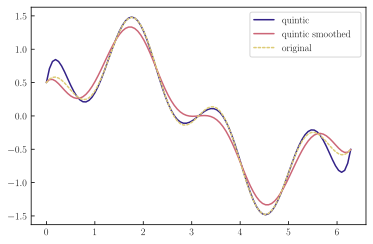

In [26]:
quint = interpolate.UnivariateSpline(xd, yd, k=5, s=0)
quints = interpolate.UnivariateSpline(xd, yd, k=5, s=0.1)
plt.plot(x, quint(x), label='quintic')
plt.plot(x, quints(x), label='quintic smoothed')
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Monotonicty
PCHIP provides a cubic splines which preserves monotonicity in data and does not overshoot on discontinuous data.

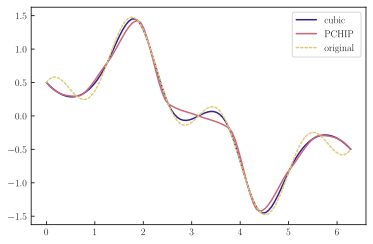

In [27]:
cubic = interpolate.CubicSpline(xd, yd)
pchip = interpolate.PchipInterpolator(xd, yd)
plt.plot(x, cubic(x), label='cubic')
plt.plot(x, pchip(x), label='PCHIP')
plt.plot(x, y, ls=':', label='original')
plt.legend()

#### Discontinuous data
In the last example PCHIP performed worse than the cubic spline because the sampled data were monotonous even though the original function was not. Its strength shows when applied to discontinous functions.

In [28]:
g = lambda x: np.where(x<np.pi, np.sin(x), np.cos(x))

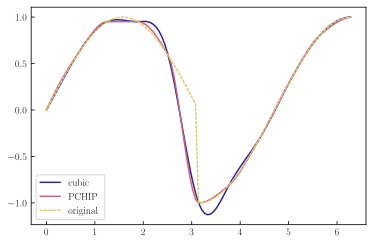

In [29]:
cubic = interpolate.CubicSpline(xd, g(xd))
pchip = interpolate.PchipInterpolator(xd, g(xd))
plt.plot(x, cubic(x), label='cubic')
plt.plot(x, pchip(x), label='PCHIP')
plt.plot(x, g(x), ls=':', label='original')
plt.legend()

### Derivatives
Splines naturally provide derivates. The argument to `derivate` specifies the order of the derivate. -1 computes the antiderivative.

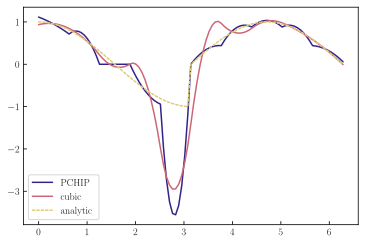

In [30]:
cubicd = cubic.derivative(); pchipd = pchip.derivative()
# Analytic derivative
gd = lambda x: np.where(x<np.pi, np.cos(x), -np.sin(x))
plt.plot(x, pchipd(x), label='PCHIP')
plt.plot(x, cubicd(x), label='cubic')
plt.plot(x, gd(x), ls=':', label='analytic')
plt.legend()

#### Smooth example

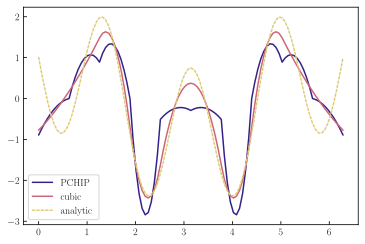

In [31]:
cubicd = interpolate.CubicSpline(xd, f(xd)).derivative()
pchipd = interpolate.PchipInterpolator(xd, f(xd)).derivative()
fd = lambda x: np.cos(x) - 0.5 * 3.5 * np.sin(3.5 * x)
plt.plot(x, pchipd(x), label='PCHIP')
plt.plot(x, cubicd(x), label='cubic')
plt.plot(x, fd(x), ls=':', label='analytic')
plt.legend()

### Extrapolation
By default the interpolators raise an exception when applied outside the range of input data. We can set a fixed value for this range or allow extrapolation.

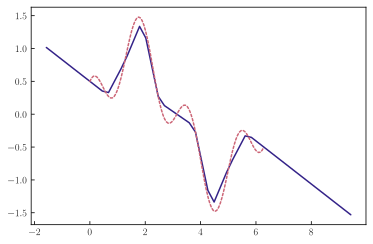

In [32]:
interp = interpolate.interp1d(xd, yd, kind='linear',
                              fill_value='extrapolate')
extrax = np.linspace(-0.5 * np.pi, 3 * np.pi)
plt.plot(extrax, interp(extrax))
plt.plot(x, y, ls=':', label='original')

### Polynomial interpolation
$n$ data points can be interpolated with a single polynomial function of degree $n-1$.

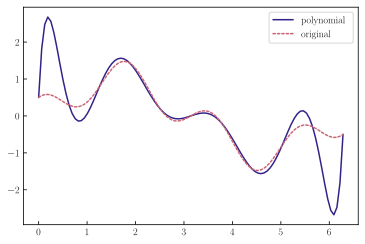

In [33]:
poly = interpolate.BarycentricInterpolator(xd,yd)
plt.plot(x,poly(x), label='polynomial')
plt.plot(x, y, ls=':', label='original')
plt.legend()

Equidistant data points combinded with high order polynomials generally produce strong oscillations at the boundary of the domain. This is known as Runge's phenomenon. This can be reduced by using splines (above) or choosing another set of nodes.

In [34]:
# Chebyshev nodes
a, b = 0, 2 * np.pi
xc = 0.5*(np.cos(np.pi*(2*np.arange(1,11) - 1)/(2*10))*(b-a) + a + b)
yc = f(xc)

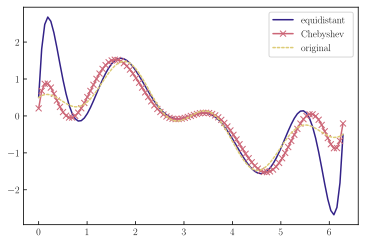

In [35]:
polycheb = interpolate.BarycentricInterpolator(xc,yc)
plt.plot(x,poly(x), label='equidistant')
plt.plot(x,polycheb(x), marker='x', label='Chebyshev')
plt.plot(x, y, ls=':', label='original')
plt.legend()

### Multidimensional data
The interpolate module offers bivariate splines with variable degree in both dimensions. This only supports Cartesian geometry.

In [36]:
# generate data
h = lambda x, y: np.exp(-x**2-y**2)
# fine grid
X, Y = np.meshgrid(np.linspace(-1,1,101),np.linspace(-1,1,101))
# coarse grid
Xc, Yc = np.meshgrid(np.linspace(-1,1,10),np.linspace(-1,1,10))
Z = h(X, Y)
Zc = h(Xc, Yc)

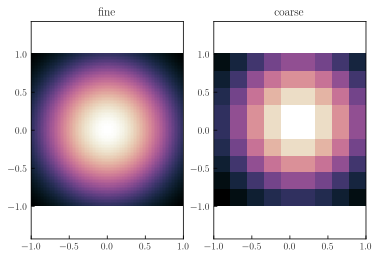

In [37]:
plt.subplot(121); plt.axis('equal'); plt.title('fine')
plt.pcolormesh(X, Y, Z, rasterized=True)
plt.subplot(122); plt.axis('equal'); plt.title('coarse')
plt.pcolormesh(Xc, Yc, Zc, rasterized=True)

In [38]:
bspl = interpolate.SmoothBivariateSpline(Xc.flat, Yc.flat, Zc.flat)

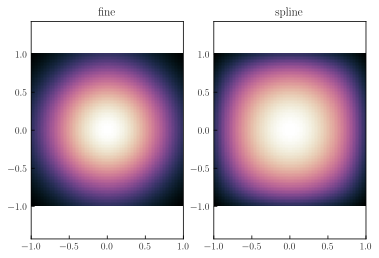

In [39]:
plt.subplot(121); plt.axis('equal'); plt.title('fine')
plt.pcolormesh(X, Y, Z, rasterized=True)
plt.subplot(122); plt.axis('equal'); plt.title('spline')
plt.pcolormesh(X, Y, bspl(X[0,:], Y[:,0]), rasterized=True)

#### Unstructrured data
`LinearNDInterpolator` takes data sampled at arbitrary points and interpolates on a triangulated grid.

In [40]:
# random sampling points
Xp = np.random.uniform(-1, 1,50)
Yp = np.random.uniform(-1, 1,50)

In [41]:
ndinterp = interpolate.LinearNDInterpolator(np.array([Xp, Yp]).T, h(Xp, Yp), fill_value=0.)

(-1.0, 1.0, -1.0, 1.1128001913215468)

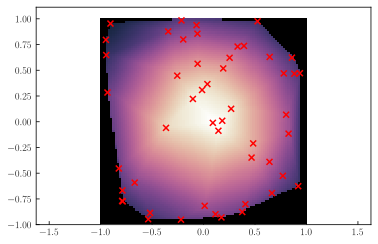

In [42]:
plt.pcolormesh(X, Y, ndinterp(X, Y), rasterized=True)
plt.scatter(Xp, Yp, marker='x', color='red'); plt.axis('equal')

## Root finding

## Fitting

## Integration

## Sparse matrices

## I/O

## Image processing